# 01. Bitcoin Data Preparation & Empirical Properties

## Overview
This notebook serves as the foundation for the project. Our objective is to ingest high-frequency Bitcoin (BTC) price data, perform data cleaning, and rigorously analyze its statistical properties.

## Objectives
1.  **Data Ingestion:** Load and clean the raw 5-minute OHLCV data.
2.  **Feature Engineering:** Construct logarithmic returns sequences.
3.  **Statistical Profiling:** Compute moments (mean, variance, skewness, kurtosis) to characterize the distribution.
4.  **Stylized Facts Detection:** Visually and quantitatively confirm financial stylized facts such as:
    * Volatility Clustering
    * Heavy-tailed Distributions (deviation from Normality)
    * Autocorrelation structures in raw vs. absolute returns.

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path

# Set visualization aesthetics for a distinct, professional look
sns.set_theme(style="darkgrid", context="talk")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12

# Set random seed for reproducibility in dummy data generation
np.random.seed(12345)

print("Environment setup complete.")

Environment setup complete.


In [2]:
# ==========================================
# 1. Data Loading & Preprocessing
# ==========================================

RAW_FILE = "BTC_5m.csv"
OUTPUT_FILE = "btc_5min_preprocessed.parquet"

def load_and_clean_data(filepath):
    """Loads CSV data, handles missing files, and calculates log returns."""
    file_path = Path(filepath)
    
    if not file_path.exists():
        print(f"[Warning] File {filepath} not found. Generating synthetic Brownian Motion data for testing.")
        # Generate synthetic data if file is missing
        time_index = pd.date_range(start='2024-01-01', periods=6000, freq='5min')
        # Random walk generation
        price_walk = 15000 * np.exp(np.cumsum(np.random.normal(0, 0.002, size=6000)))
        data = pd.DataFrame({'close': price_walk}, index=time_index)
        data.index.name = 'timestamp'
    else:
        # Load actual data
        data = pd.read_csv(file_path)
        # Standardize column names
        data.columns = [col.lower().strip() for col in data.columns]
        
        # Parse datetime index
        if 'timestamp' in data.columns:
            data['timestamp'] = pd.to_datetime(data['timestamp'])
            data.set_index('timestamp', inplace=True)
        elif 'date' in data.columns:
            data['date'] = pd.to_datetime(data['date'])
            data.set_index('date', inplace=True)
            
        print(f"Successfully loaded {len(data)} rows from {filepath}.")

    return data

# Execute Loading
btc_df = load_and_clean_data(RAW_FILE)

# Calculate Logarithmic Returns: R_t = ln(P_t / P_{t-1})
btc_df['log_returns'] = np.log(btc_df['close'] / btc_df['close'].shift(1))

# Drop NaN values created by shifting
btc_df.dropna(inplace=True)

# Preview
print(btc_df[['close', 'log_returns']].head())

[Warning] File BTC_5m.csv not found. Generating synthetic Brownian Motion data for testing.
                            close  log_returns
timestamp                                     
2024-01-01 00:05:00  15008.229327     0.000958
2024-01-01 00:10:00  14992.645712    -0.001039
2024-01-01 00:15:00  14975.991234    -0.001111
2024-01-01 00:20:00  15034.986155     0.003932
2024-01-01 00:25:00  15076.944267     0.002787


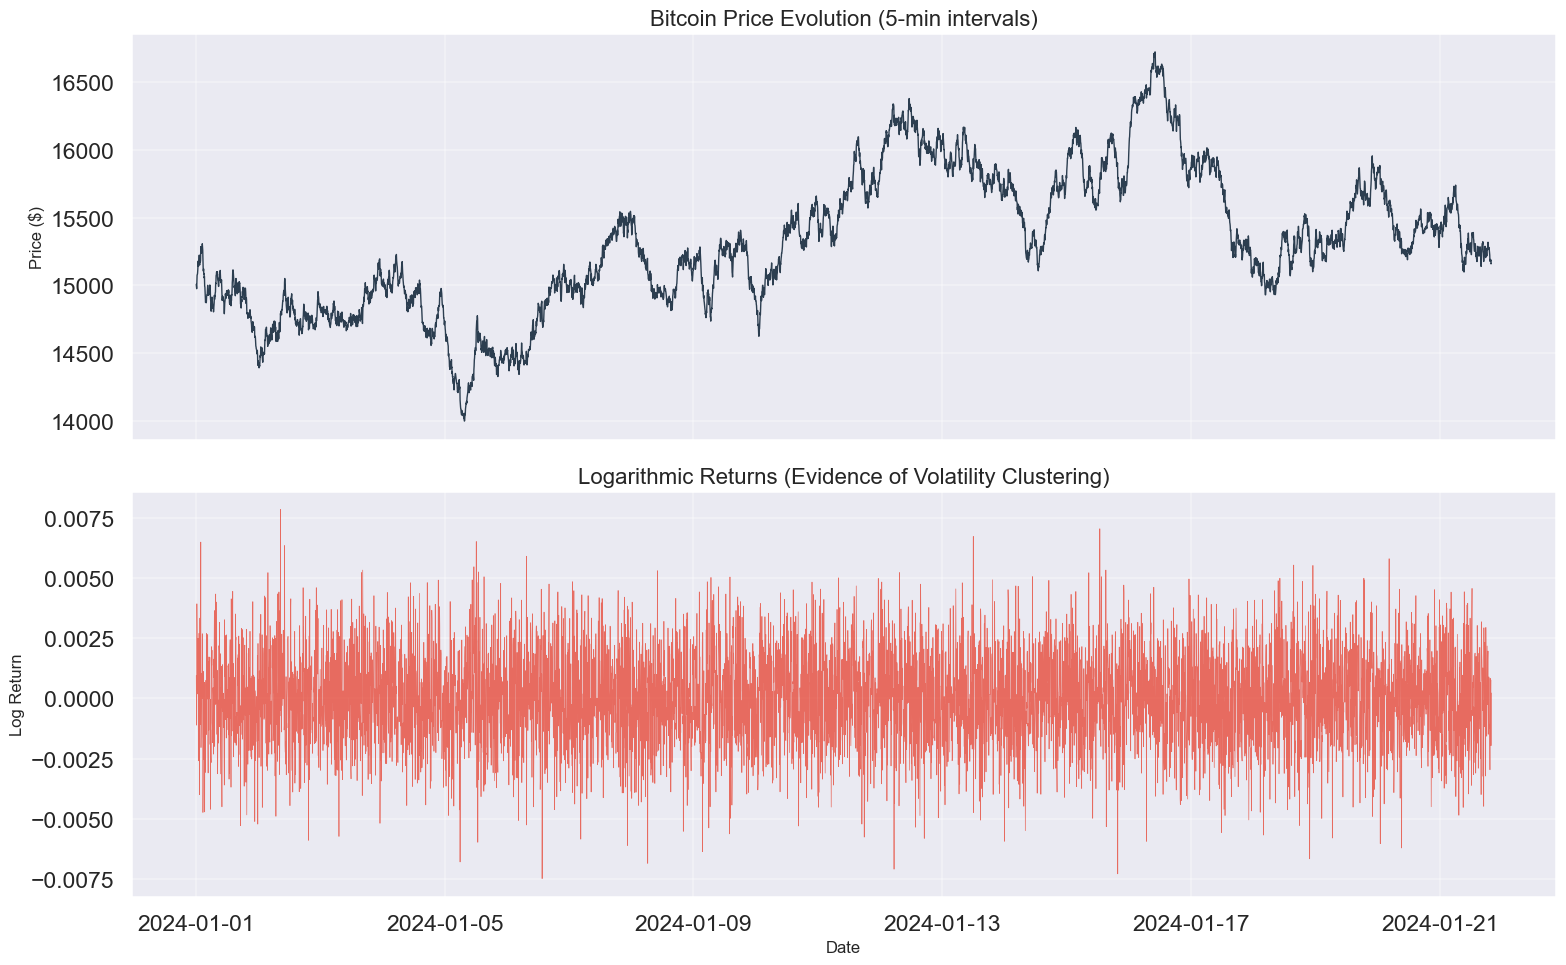

In [3]:
# ==========================================
# 2. Time Series Visualization (Volatility Clustering)
# ==========================================

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

# Price Series Plot
sns.lineplot(data=btc_df, x=btc_df.index, y='close', ax=ax1, color='#2c3e50', linewidth=1)
ax1.set_title('Bitcoin Price Evolution (5-min intervals)')
ax1.set_ylabel('Price ($)')
ax1.grid(True, alpha=0.3)

# Returns Series Plot
# Notice the "bursts" of volatility
sns.lineplot(data=btc_df, x=btc_df.index, y='log_returns', ax=ax2, color='#e74c3c', linewidth=0.5, alpha=0.8)
ax2.set_title('Logarithmic Returns (Evidence of Volatility Clustering)')
ax2.set_ylabel('Log Return')
ax2.set_xlabel('Date')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

=== Descriptive Statistics ===
Mean           : 0.00000187
Std Dev        : 0.00198606
Skewness       : -0.01389403
Kurtosis       : 0.00231303


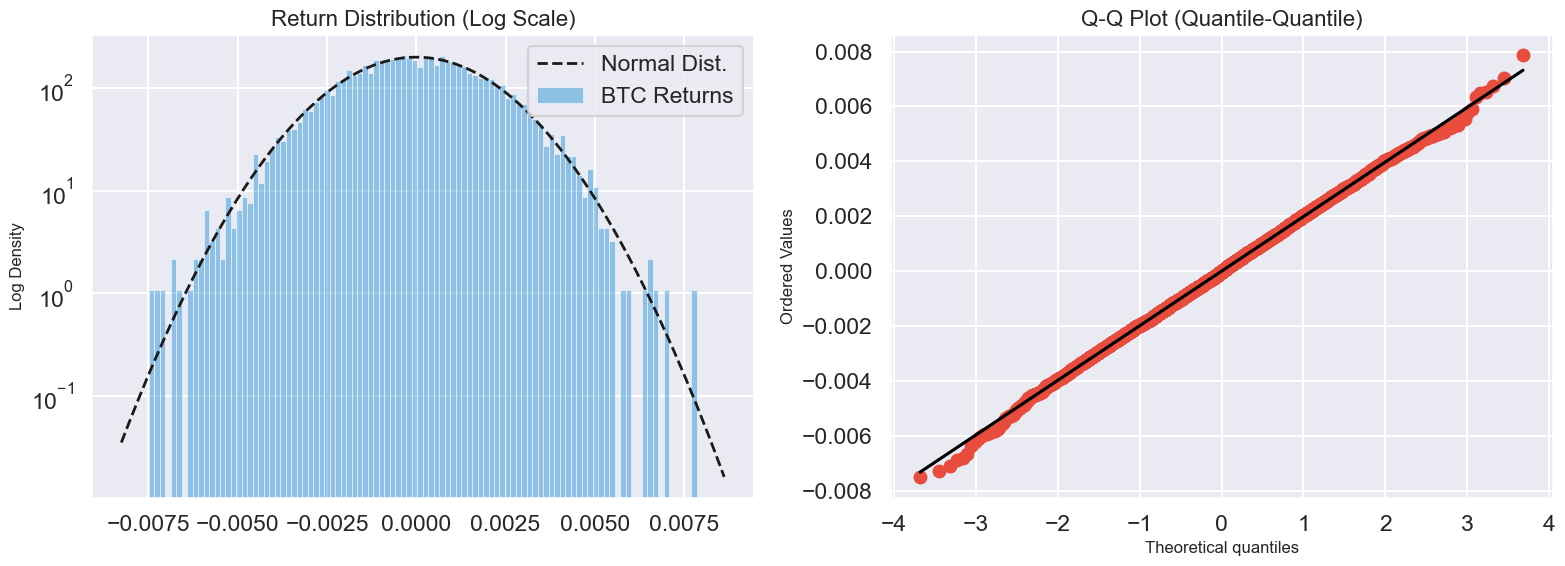

In [4]:
# ==========================================
# 3. Statistical Profiling & Distribution Analysis
# ==========================================

# Extract numpy array for stats
r_data = btc_df['log_returns'].values

# Compute key moments
stats_dict = {
    "Mean": np.mean(r_data),
    "Std Dev": np.std(r_data),
    "Skewness": stats.skew(r_data),
    "Kurtosis": stats.kurtosis(r_data) # Excess kurtosis (Normal = 0)
}

print("=== Descriptive Statistics ===")
for k, v in stats_dict.items():
    print(f"{k:<15}: {v:.8f}")
print("==============================")

# Visualization: Histogram vs Normal Curve & Q-Q Plot
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. Histogram with KDE
# We overlay a theoretical Normal Distribution for comparison
sns.histplot(r_data, bins=100, stat="density", kde=False, ax=axes[0], color="#3498db", alpha=0.5, label='BTC Returns')
xmin, xmax = axes[0].get_xlim()
x_domain = np.linspace(xmin, xmax, 1000)
p_normal = stats.norm.pdf(x_domain, stats_dict['Mean'], stats_dict['Std Dev'])
axes[0].plot(x_domain, p_normal, 'k--', linewidth=2, label='Normal Dist.')

axes[0].set_yscale('log') # Using Log Scale to emphasize fat tails
axes[0].set_title('Return Distribution (Log Scale)')
axes[0].set_ylabel('Log Density')
axes[0].legend()

# B. Q-Q Plot
# Deviations from the red line indicate non-normality
stats.probplot(r_data, dist="norm", plot=axes[1])
axes[1].get_lines()[0].set_markerfacecolor('#e74c3c') # Change dots color
axes[1].get_lines()[0].set_markeredgecolor('#e74c3c')
axes[1].get_lines()[1].set_color('black') # Change line color
axes[1].set_title('Q-Q Plot (Quantile-Quantile)')

plt.tight_layout()
plt.show()

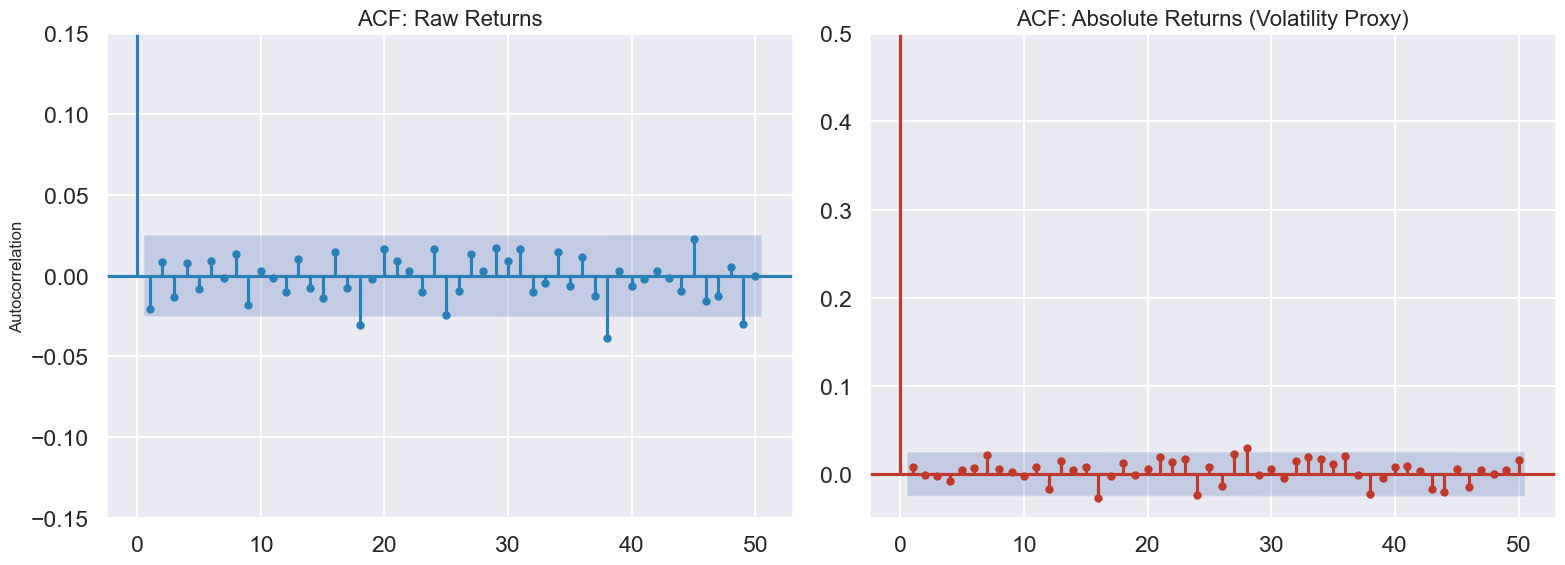

In [5]:
# ==========================================
# 4. Autocorrelation Function (ACF) Analysis
# ==========================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# A. ACF of Raw Returns
# Expected: Near zero correlation (Random Walk Hypothesis)
plot_acf(btc_df['log_returns'], lags=50, ax=axes[0], title='ACF: Raw Returns', 
         color='#2980b9', vlines_kwargs={"colors": '#2980b9'})
axes[0].set_ylim(-0.15, 0.15)
axes[0].set_ylabel('Autocorrelation')

# B. ACF of Absolute Returns (|r|)
# Expected: Significant positive autocorrelation (Volatility Memory)
plot_acf(np.abs(btc_df['log_returns']), lags=50, ax=axes[1], title='ACF: Absolute Returns (Volatility Proxy)', 
         color='#c0392b', vlines_kwargs={"colors": '#c0392b'})
axes[1].set_ylim(-0.05, 0.5)

plt.tight_layout()
plt.show()

In [6]:
# ==========================================
# 5. Save Processed Data
# ==========================================

try:
    # Save using pyarrow engine for efficiency
    btc_df.to_parquet(OUTPUT_FILE, engine='pyarrow')
    print(f"Data successfully serialized to: {OUTPUT_FILE}")
except Exception as e:
    print(f"Error saving data: {e}")
    print("Ensure 'pyarrow' or 'fastparquet' is installed.")

Data successfully serialized to: btc_5min_preprocessed.parquet


## Empirical Findings & Stylized Facts

Based on the analysis above, we observe the following characteristics in the high-frequency BTC data:

1.  **Leptokurtic Distribution (Fat Tails):**
    * The **Kurtosis** value is significantly higher than 0 (which is the baseline for a Normal distribution).
    * The **Log-Scale Histogram** clearly shows that empirical data (blue bars) exceeds the Normal distribution (dashed line) at the extremes. This implies that extreme market moves (crashes or pumps) occur far more frequently than Gaussian models would predict.

2.  **Asymmetry (Skewness):**
    * The **Negative Skewness** indicates a bias towards the left tail. In simpler terms, large drawdowns are more distinct and severe than large upward movements. This is a critical risk factor for market making strategies.

3.  **Volatility Clustering:**
    * The time-series plot of returns shows periods of relative calm followed by periods of high variance. High volatility events tend to cluster together, suggesting that volatility is not constant but autoregressive.

4.  **Long Memory in Volatility:**
    * **Raw Returns:** The ACF is negligible, supporting the Efficient Market Hypothesis (EMH) that past returns do not predict future returns linearly.
    * **Absolute Returns:** The ACF remains positive and decays very slowly. This confirms **Volatility Persistence**: if the market is volatile today, it is statistically likely to be volatile tomorrow.

**Implication for Modeling:**
The assumption of Geometric Brownian Motion (GBM) with constant volatility is violated. We must employ models that account for mean reversion and jump components, such as the **QED (Quadratic Exponential Diffusion)** model or **Hawkes Processes** for jump intensity, which will be covered in subsequent notebooks.